In [1]:
import xgboost as xgb
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
plt.style.use('ggplot')
from sklearn import metrics
from datetime import datetime
import seaborn as sns
from keras.models import Sequential
from keras.layers import Dense
from keras.utils import model_to_dot
from keras.utils import plot_model
from mlxtend.preprocessing import TransactionEncoder
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error,r2_score
from statistics import variance
from sklearn.svm import SVR
from sklearn.neighbors import KNeighborsRegressor
from sklearn.ensemble import RandomForestRegressor,RandomForestClassifier,ExtraTreesClassifier
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping, LambdaCallback
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report
from sklearn.model_selection import KFold, cross_val_score,GridSearchCV
from sklearn.feature_selection import RFE
from xgboost import cv
from sklearn.metrics import make_scorer

### Read the Apt. Dataset

In [2]:
Apt_dataset=pd.read_csv("Apt_dataset.csv")

### Spliting the features and target Variable

In [12]:
X=Apt_dataset.drop(['List Price', 'Sold Price', 'Days on Market','Sale to List %','price class', 'log price'],axis=1)
Y=Apt_dataset[['Sold Price','log price','price class','List Price']]

### Dataset Standardization and scaling

In [13]:
from sklearn.preprocessing import StandardScaler
def X_norm(df):
    ndf=pd.DataFrame()
    for col in df.columns:
        #norm btw 0 and 1
        ndf[col]=df[col]/max(df[col])
    #Z_score for 'Taxes' and 'Maint. Fees'
    std_scaler = StandardScaler()
    ndf[['Taxes','Maint. Fees']] = std_scaler.fit_transform(ndf[['Taxes','Maint. Fees']].values.tolist())
    return ndf

nX=X_norm(X)
nY=Y.copy(deep=True)
_MAX_Y=max(Y['Sold Price'])

nY['Sold Price']=Y['Sold Price']/_MAX_Y
nY['List Price']=Y['List Price']/_MAX_Y

### Creating the Training and Test Sets for the Apt dataset

In [14]:
X_train, X_test, Y_train, Y_test = train_test_split(nX, nY, test_size=0.15,stratify=nY[["price class"]])

### Goodness of fit function

In [15]:
def GoF(y_true, y_pred,summary=True,plot=True,title='cumulative distribution of APE Curve'):
    APE=np.abs((y_true - y_pred) / y_true)
    score=[]
    N=len(y_true)
    for i in range(101):
        T=sum(APE<=i/100.0)
        score.append(T/N)
    AUC=np.trapz(score, dx=0.01)
    MAPE=np.average(np.abs(y_true - y_pred) / y_true, axis=0)*100
    RMSE=np.sqrt(mean_squared_error(y_true, y_pred))
    R2=r2_score(y_true, y_pred)
    dict_error={'Value':[_MAX_Y*RMSE,R2,MAPE,AUC]}
    index_error=['RMSE','R2','MAPE%',"AUC"]
    df = pd.DataFrame(dict_error,index=index_error)
    
    if plot:
        plt.figure(figsize=(5, 5))
        plt.plot(np.linspace(0,1.01,101),score,label=f'AUC = {round(AUC,2)}')
        plt.plot(0.05,score[5],'rs', label=f'APE<5% : {round(score[5]*100,2)}%')
        plt.plot(0.10,score[10],'rD', label=f'APE<10% : {round(score[10]*100,2)}%')
        plt.plot(0.20,score[20],'ro', label=f'APE<20% : {round(score[20]*100,2)}%')
        plt.legend()
        plt.title(title)
        plt.xlabel('APE')
        plt.ylabel('Cumulative distribution')
        plt.show()
        
    if summary:
        print(round(df,2).T)
        
    return score,df

######### Costum Grid Search score functions #########
def GS_score(y_true, y_pred):
    _,ES=GoF(y_true,y_pred,summary=False,plot=False)
    return (ES.T)['AUC'].values

def Log_GS_score(y_true, y_pred):
    _,ES=GoF(np.exp(y_true),np.exp(y_pred),summary=False,plot=False)
    return (ES.T)['AUC'].values

######### Mean of APE curve & its margins ######### 
def CDF_plot(CDF_mean,CDF_std,title="K-Fold Result"):
    x=np.linspace(0,1.01,101)
    plt.figure(figsize=(5, 5))
    plt.plot(x,CDF_mean,label='mean')
    plt.plot(x,CDF_mean+2*CDF_std,'--',label='mean+2*std')
    plt.plot(x,CDF_mean-2*CDF_std,'--',label='mean-2*std')
    plt.legend()
    plt.title(title)
    plt.xlabel('APE')
    plt.ylabel('Cumulative distribution')
    plt.show()

### Base line

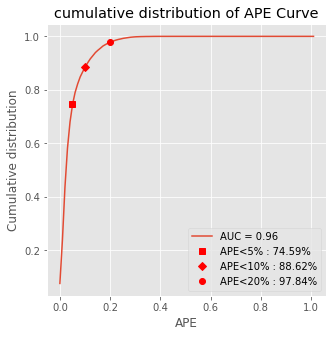

           RMSE    R2  MAPE%   AUC
Value  38636.45  0.96   4.16  0.96


In [16]:
######### The homeowner listed a value to sale as a list price ######### 
score,ES=GoF(nY['Sold Price'],nY['List Price'])

## Linear Regression Model

### Target: Sold Price

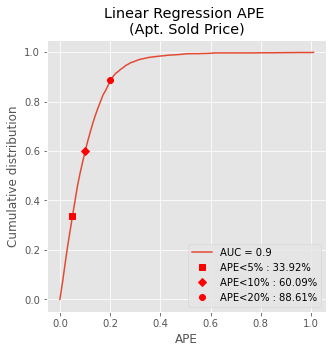

           RMSE    R2  MAPE%  AUC
Value  66734.81  0.88  10.31  0.9


In [10]:
LR= LinearRegression()
LR.fit(X_train, Y_train['Sold Price'])
y_pred=LR.predict(X_test)
score,ES=GoF(Y_test['Sold Price'],y_pred,title="Linear Regression APE \n(Apt. Sold Price)")

### K-Fold Cross Validation for the Linear Regression model K=50

1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48 49 50             mean       std
RMSE   69777.754  5510.692
R2         0.871     0.019
MAPE%     10.505     0.532
AUC        0.895     0.005


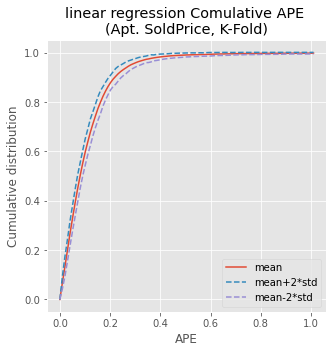

             mean       std
APE<5%   0.330223  0.025899
APE<10%  0.598145  0.026779
APE<20%  0.879593  0.014946


In [9]:
CDF=[]
dict_error={'Value':[0,0,0,0]}
index_error=['RMSE','R2','MAPE%',"AUC"]
ES = pd.DataFrame(dict_error,index=index_error)
num_fold=50
i=0
folds = KFold(n_splits = num_fold, shuffle = True, random_state = 100)
for train_index, test_index in folds.split(nX, nY):
    LR= LinearRegression().fit(nX.iloc[train_index], nY.iloc[train_index]['Sold Price'])                            
    y_pred=LR.predict(nX.iloc[test_index])
    cdf,es=GoF(nY.iloc[test_index]['Sold Price'],y_pred,summary=False,plot=False)
    
    CDF.append(cdf)
    ES[i]=es
    i+=1
    print(i,end=' ')
    
ES=ES.drop('Value',axis=1)
ES['mean']=ES.mean(axis=1)
ES['std']=ES.std(axis=1)
ES=ES[['mean','std']]    
print(ES.round(3))

CDF=np.array(CDF)
CDF_mean=CDF.mean(axis=0)
CDF_std=CDF.std(axis=0)
CDF_plot(CDF_mean,CDF_std,title="linear regression Comulative APE \n(Apt. SoldPrice, K-Fold)")
dict_ACC={'mean':CDF_mean[[5,10,20]],'std':CDF_std[[5,10,20]]}
index_ACC=['APE<5%','APE<10%','APE<20%']
print(pd.DataFrame(dict_ACC,index=index_ACC))

### Linear regression with Target: log price

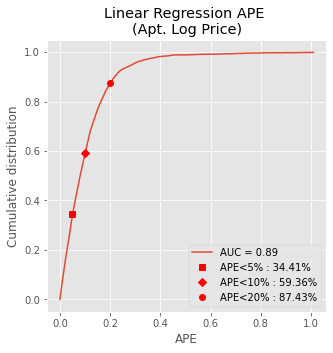

           RMSE    R2  MAPE%   AUC
Value  86407.98  0.81  10.58  0.89


In [12]:
LR= LinearRegression()
LR.fit(X_train, Y_train['log price'])
y_pred=np.exp(LR.predict(X_test))/_MAX_Y
score,ES=GoF(Y_test['Sold Price'],y_pred,title="Linear Regression APE \n(Apt. Log Price)")

### K-Fold Cross Validation (Log of Sold Price), K=50

1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48 49 50             mean        std
RMSE   89587.293  16959.766
R2         0.786      0.069
MAPE%     10.702      0.537
AUC        0.893      0.005


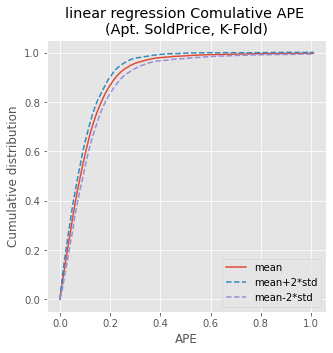

             mean       std
APE<5%   0.328793  0.025598
APE<10%  0.591516  0.025023
APE<20%  0.871586  0.016419


In [17]:
CDF=[]
dict_error={'Value':[0,0,0,0]}
index_error=['RMSE','R2','MAPE%',"AUC"]
ES = pd.DataFrame(dict_error,index=index_error)
num_fold=50
i=0
folds = KFold(n_splits = num_fold, shuffle = True, random_state = 100)
for train_index, test_index in folds.split(nX, nY):
    LR= LinearRegression().fit(nX.iloc[train_index], nY.iloc[train_index]['log price'])                            
    y_pred=np.exp(LR.predict(nX.iloc[test_index]))/_MAX_Y
    cdf,es=GoF(nY.iloc[test_index]['Sold Price'],y_pred,summary=False,plot=False)
    
    CDF.append(cdf)
    ES[i]=es
    i+=1
    print(i,end=' ')
    
ES=ES.drop('Value',axis=1)
ES['mean']=ES.mean(axis=1)
ES['std']=ES.std(axis=1)
ES=ES[['mean','std']]    
print(ES.round(3))

CDF=np.array(CDF)
CDF_mean=CDF.mean(axis=0)
CDF_std=CDF.std(axis=0)
CDF_plot(CDF_mean,CDF_std,title="linear regression Comulative APE \n(Apt. SoldPrice, K-Fold)")
dict_ACC={'mean':CDF_mean[[5,10,20]],'std':CDF_std[[5,10,20]]}
index_ACC=['APE<5%','APE<10%','APE<20%']
print(pd.DataFrame(dict_ACC,index=index_ACC))

## KNN Model

### Hyperparameters Optimization With Grid Search method

## Target: Sold Price

In [16]:
AUC = make_scorer(GS_score)
parameters = {'n_neighbors':range(6,19)}
KNN_base = KNeighborsRegressor(weights='distance',algorithm='brute', p=1,metric='minkowski') 
KNN_tuned = GridSearchCV(KNN_base, parameters,cv = 5,scoring= AUC)
KNN_opt_sold=KNN_tuned.fit(X_train, Y_train['Sold Price'])
print("Best AUC: " + str(KNN_opt_sold.best_score_) + "\n")
print("Optimal Model:\n" + str(KNN_opt.best_estimator_) + "\n")
print(KNN_opt.best_params_)

Best AUC: 0.8678623036544284

Optimal Model:
KNeighborsRegressor(algorithm='brute', n_neighbors=11, p=1, weights='distance')

{'n_neighbors': 11}


#### Test the model with the best parameters and plot the result

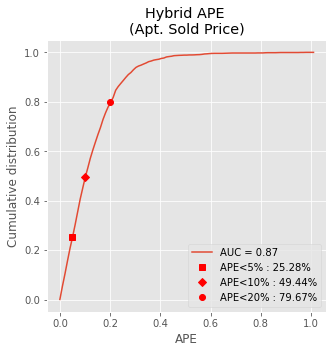

           RMSE    R2  MAPE%   AUC
Value  81941.16  0.82  12.81  0.87


In [17]:
y_pred=KNN_opt_sold.predict(X_test)
score,ES=GoF(Y_test['Sold Price'],y_pred,title="KNN APE \n(Apt. Sold Price)")

#### K-FOLD CROSS VALIDATION for the KNN model,K=50

1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48 49 50             mean       std
RMSE   83972.275  5890.334
R2         0.814     0.025
MAPE%     12.779     0.583
AUC        0.872     0.006


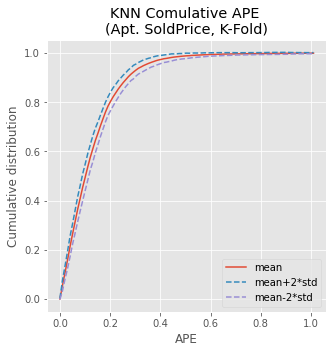

             mean       std
APE<5%   0.264490  0.020662
APE<10%  0.495768  0.026841
APE<20%  0.804085  0.018859


In [10]:
CDF=[]
dict_error={'Value':[0,0,0,0]}
index_error=['RMSE','R2','MAPE%',"AUC"]
ES = pd.DataFrame(dict_error,index=index_error)
num_fold=50
i=0
folds = KFold(n_splits = num_fold, shuffle = True, random_state = 100)
for train_index, test_index in folds.split(nX, nY):
    KNN= KNeighborsRegressor(n_neighbors=11,weights='distance',algorithm='brute', p=1,
                             metric='minkowski').fit(nX.iloc[train_index],
                                                     nY.iloc[train_index]['Sold Price'])
    y_pred=KNN.predict(nX.iloc[test_index])
    cdf,es=GoF(nY.iloc[test_index]['Sold Price'],y_pred,summary=False,plot=False)
    
    CDF.append(cdf)
    ES[i]=es
    i+=1
    print(i,end=' ')
    
ES=ES.drop('Value',axis=1)
ES['mean']=ES.mean(axis=1)
ES['std']=ES.std(axis=1)
ES=ES[['mean','std']]    
print(ES.round(3))

CDF=np.array(CDF)
CDF_mean=CDF.mean(axis=0)
CDF_std=CDF.std(axis=0)
CDF_plot(CDF_mean,CDF_std,title="KNN Comulative APE \n(Apt. SoldPrice, K-Fold)")
dict_ACC={'mean':CDF_mean[[5,10,20]],'std':CDF_std[[5,10,20]]}
index_ACC=['APE<5%','APE<10%','APE<20%']
print(pd.DataFrame(dict_ACC,index=index_ACC))

### Hyperparameters Optimization With the Grid Search method Target: Log Price

In [13]:
AUC = make_scorer(Log_GS_score)
parameters = {'n_neighbors':range(6,19)}
KNN_base = KNeighborsRegressor(weights='distance',algorithm='brute', p=1,metric='minkowski') 
KNN_tuned = GridSearchCV(KNN_base, parameters,cv = 5,scoring= AUC)
KNN_opt=KNN_tuned.fit(X_train, Y_train['log price'])
print("Best AUC: " + str(KNN_opt.best_score_) + "\n")
print("Optimal Model:\n" + str(KNN_opt.best_estimator_) + "\n")
print(KNN_opt.best_params_)

Best AUC: 0.9894902414685186

Optimal Model:
KNeighborsRegressor(algorithm='brute', n_neighbors=11, p=1, weights='distance')

{'n_neighbors': 11}


### Test the model with the best parameters and plot the result

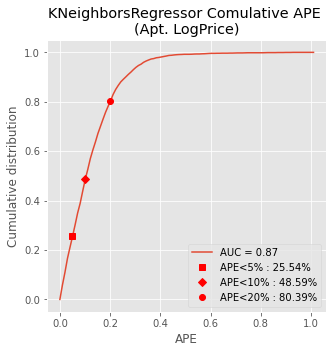

           RMSE    R2  MAPE%   AUC
Value  84772.03  0.81  12.64  0.87


In [15]:
knn_predictions = np.exp(KNN_opt.predict(X_test))/_MAX_Y
score,ES=GoF(Y_test['Sold Price'],knn_predictions,title="KNeighborsRegressor Comulative APE \n(Apt. LogPrice)") 

### K-Fold Cross Validation for the KNN Model, Target: Log Price

1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48 49 50             mean       std
RMSE   86026.698  6125.821
R2         0.805     0.024
MAPE%     12.561     0.574
AUC        0.874     0.006


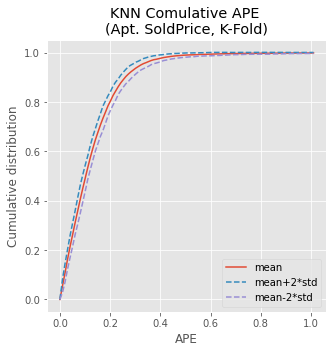

             mean       std
APE<5%   0.261590  0.023598
APE<10%  0.492187  0.026443
APE<20%  0.806147  0.018961


In [14]:
CDF=[]
dict_error={'Value':[0,0,0,0]}
index_error=['RMSE','R2','MAPE%',"AUC"]
ES = pd.DataFrame(dict_error,index=index_error)
num_fold=50
i=0
folds = KFold(n_splits = num_fold, shuffle = True, random_state = 100)
for train_index, test_index in folds.split(nX, nY):
    KNN= KNeighborsRegressor(n_neighbors=11,weights='distance',algorithm='brute', p=1,
                             metric='minkowski').fit(nX.iloc[train_index],
                                                     nY.iloc[train_index]['log price'])
    y_pred=np.exp(KNN.predict(nX.iloc[test_index]))/_MAX_Y
    cdf,es=GoF(nY.iloc[test_index]['Sold Price'],y_pred,summary=False,plot=False)
    
    CDF.append(cdf)
    ES[i]=es
    i+=1
    print(i,end=' ')
    
ES=ES.drop('Value',axis=1)
ES['mean']=ES.mean(axis=1)
ES['std']=ES.std(axis=1)
ES=ES[['mean','std']]    
print(ES.round(3))

CDF=np.array(CDF)
CDF_mean=CDF.mean(axis=0)
CDF_std=CDF.std(axis=0)
CDF_plot(CDF_mean,CDF_std,title="KNN Comulative APE \n(Apt. SoldPrice, K-Fold)")
dict_ACC={'mean':CDF_mean[[5,10,20]],'std':CDF_std[[5,10,20]]}
index_ACC=['APE<5%','APE<10%','APE<20%']
print(pd.DataFrame(dict_ACC,index=index_ACC))

### Linear regression Coefficients

In [24]:
LR = LinearRegression()
LR.fit(X_train, Y_train['Sold Price'])
dict_coef={'Coefficients':LR.coef_}
index_coef=X_train.columns
df = pd.DataFrame(dict_coef,index=index_coef)
df.T

,Bedrooms AG,Bedrooms BG,Washrooms,Family Room,Square Feet,Taxes,Maint. Fees,AC Type,Heat Type,Heat included,...,E07,E08,C08,E10,E05,E01,W04,W10,C10,C01
Coefficients,0.007371,-0.002058,0.027926,0.00579,0.293316,0.08483,0.000143,0.013079,-0.001354,-0.003303,...,4.743482e+08,4.743482e+08,4.743482e+08,4.743482e+08,4.743482e+08,4.743482e+08,4.743482e+08,4.743482e+08,4.743482e+08,4.743482e+08


## Hybrid Model

### Target: Sold Price

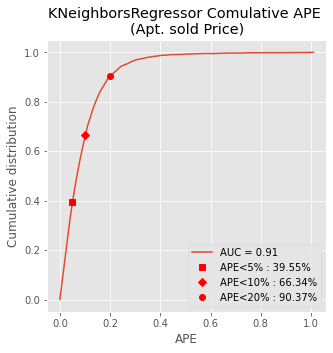

           RMSE    R2  MAPE%   AUC
Value  67137.61  0.88   9.28  0.91


In [36]:
LR = LinearRegression()
LR.fit(X_train, Y_train['Sold Price'])
weights=np.abs(LR.coef_)/np.sum(np.abs(LR.coef_))
KNN= KNeighborsRegressor(n_neighbors=8, weights='distance',
                          algorithm='brute', metric='wminkowski',
                          metric_params={'w': weights},p=1)
KNN.fit(X_train, Y_train['Sold Price'])
y_pred=KNN.predict(X_test)
score,ES=GoF(Y_test['Sold Price'],y_pred,title="Hybrid Comulative APE \n(Apt. sold Price)") 

### K-Fold Cross Validation for the Hybrid Model, k=50

1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48 49 50             mean       std
RMSE   68988.688  6402.684
R2         0.874     0.022
MAPE%      9.035     0.477
AUC        0.910     0.004


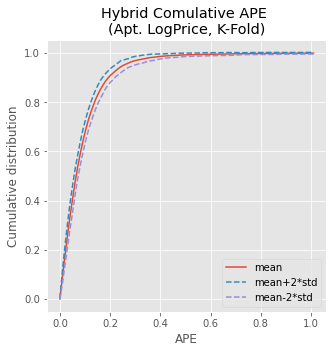

             mean       std
APE<5%   0.406466  0.027273
APE<10%  0.680634  0.022198
APE<20%  0.909215  0.013910


In [11]:
CDF=[]
dict_error={'Value':[0,0,0,0]}
index_error=['RMSE','R2','MAPE%',"AUC"]
ES = pd.DataFrame(dict_error,index=index_error)
num_fold=50
i=0
folds = KFold(n_splits = num_fold, shuffle = True, random_state = 100)
for train_index, test_index in folds.split(nX, nY):
    LR = LinearRegression()
    LR.fit(X_train, Y_train['Sold Price'])
    weights=np.abs(LR.coef_)/np.sum(np.abs(LR.coef_))
    KNN_LR= KNeighborsRegressor(n_neighbors=8, weights='distance',algorithm='brute', metric='wminkowski',
                              metric_params={'w': weights},p=1).fit(nX.iloc[train_index],nY.iloc[train_index]['Sold Price'])                                             
                                
    y_pred=KNN_LR.predict(nX.iloc[test_index])
    cdf,es=GoF(nY.iloc[test_index]['Sold Price'],y_pred,summary=False,plot=False)
    
    CDF.append(cdf)
    ES[i]=es
    i+=1
    print(i,end=' ')
    
ES=ES.drop('Value',axis=1)
ES['mean']=ES.mean(axis=1)
ES['std']=ES.std(axis=1)
ES=ES[['mean','std']]    
print(ES.round(3))

CDF=np.array(CDF)
CDF_mean=CDF.mean(axis=0)
CDF_std=CDF.std(axis=0)
CDF_plot(CDF_mean,CDF_std,title="Hybrid Comulative APE \n(Apt. LogPrice, K-Fold)")
dict_ACC={'mean':CDF_mean[[5,10,20]],'std':CDF_std[[5,10,20]]}
index_ACC=['APE<5%','APE<10%','APE<20%']
print(pd.DataFrame(dict_ACC,index=index_ACC))

### Target: Log Price

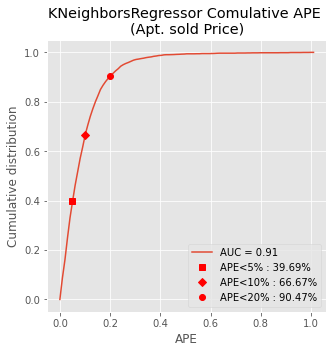

           RMSE    R2  MAPE%   AUC
Value  67579.64  0.88   9.13  0.91


In [37]:
LR = LinearRegression()
LR.fit(X_train, Y_train['Sold Price'])
weights=np.abs(LR.coef_)/np.sum(np.abs(LR.coef_))
KNN= KNeighborsRegressor(n_neighbors=8, weights='distance',
                          algorithm='brute', metric='wminkowski',
                          metric_params={'w': weights},p=1)
KNN.fit(X_train, Y_train['log price'])
y_pred=np.exp(KNN.predict(X_test))/_MAX_Y
score,ES=GoF(Y_test['Sold Price'],y_pred,title="KNN&LR Comulative APE \n(Apt. sold Price)") 

### Hybrid K-Fold Cross Validation, K=50

1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48 49 50             mean       std
RMSE   69511.898  6724.801
R2         0.872     0.023
MAPE%      8.909     0.462
AUC        0.911     0.004


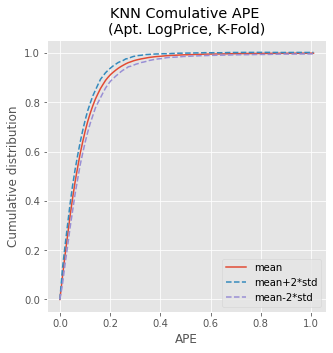

             mean       std
APE<5%   0.410199  0.025627
APE<10%  0.683974  0.022440
APE<20%  0.912507  0.013240


In [12]:
CDF=[]
dict_error={'Value':[0,0,0,0]}
index_error=['RMSE','R2','MAPE%',"AUC"]
ES = pd.DataFrame(dict_error,index=index_error)
num_fold=50
i=0
folds = KFold(n_splits = num_fold, shuffle = True, random_state = 100)
for train_index, test_index in folds.split(nX, nY):
    LR = LinearRegression()
    LR.fit(X_train, Y_train['Sold Price'])
    weights=np.abs(LR.coef_)/np.sum(np.abs(LR.coef_))
    KNN_LR= KNeighborsRegressor(n_neighbors=8, weights='distance',algorithm='brute', metric='wminkowski',
                              metric_params={'w': weights},p=1).fit(nX.iloc[train_index],nY.iloc[train_index]['log price'])                                             
                                
    y_pred=np.exp(KNN_LR.predict(nX.iloc[test_index]))/_MAX_Y
    cdf,es=GoF(nY.iloc[test_index]['Sold Price'],y_pred,summary=False,plot=False)
    
    CDF.append(cdf)
    ES[i]=es
    i+=1
    print(i,end=' ')
    
ES=ES.drop('Value',axis=1)
ES['mean']=ES.mean(axis=1)
ES['std']=ES.std(axis=1)
ES=ES[['mean','std']]    
print(ES.round(3))

CDF=np.array(CDF)
CDF_mean=CDF.mean(axis=0)
CDF_std=CDF.std(axis=0)
CDF_plot(CDF_mean,CDF_std,title="Hybrid Comulative APE \n(Apt. LogPrice, K-Fold)")
dict_ACC={'mean':CDF_mean[[5,10,20]],'std':CDF_std[[5,10,20]]}
index_ACC=['APE<5%','APE<10%','APE<20%']
print(pd.DataFrame(dict_ACC,index=index_ACC))

##### Appendix

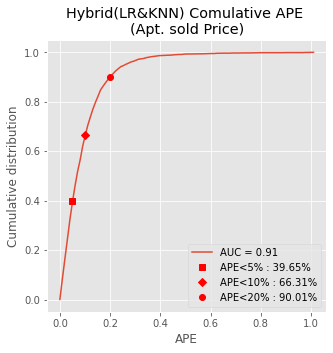

           RMSE    R2  MAPE%   AUC
Value  67310.21  0.88   9.29  0.91


In [42]:
LR = LinearRegression(fit_intercept=False)
LR.fit(X_train, Y_train['Sold Price'])
weights=np.abs(LR.coef_)/np.sum(np.abs(LR.coef_))
KNN= KNeighborsRegressor(n_neighbors=9, weights='distance',
                          algorithm='brute', metric='wminkowski',
                          metric_params={'w': weights},p=1)
KNN.fit(X_train, Y_train['Sold Price'])
y_pred=KNN.predict(X_test)
score,ES=GoF(Y_test['Sold Price'],y_pred,title="Hybrid(LR&KNN) Comulative APE \n(Apt. sold Price)") 

### Hybrid k-fold cross validation (fit-intercept=false)

1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48 49 50             mean       std
RMSE   68838.976  6222.788
R2         0.875     0.021
MAPE%      9.044     0.491
AUC        0.910     0.005


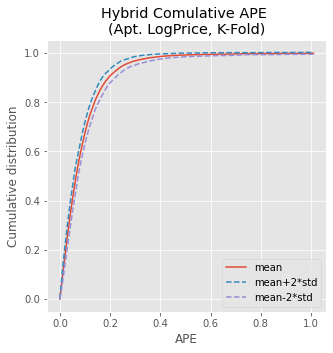

             mean       std
APE<5%   0.408283  0.025108
APE<10%  0.679846  0.021827
APE<20%  0.909215  0.014018


In [13]:
CDF=[]
dict_error={'Value':[0,0,0,0]}
index_error=['RMSE','R2','MAPE%',"AUC"]
ES = pd.DataFrame(dict_error,index=index_error)
num_fold=50
i=0
folds = KFold(n_splits = num_fold, shuffle = True, random_state = 100)
for train_index, test_index in folds.split(nX, nY):
    LR = LinearRegression(fit_intercept=False)
    LR.fit(X_train, Y_train['Sold Price'])
    weights=np.abs(LR.coef_)/np.sum(np.abs(LR.coef_))
    KNN_LR= KNeighborsRegressor(n_neighbors=8, weights='distance',algorithm='brute', metric='wminkowski',
                              metric_params={'w': weights},p=1).fit(nX.iloc[train_index],nY.iloc[train_index]['Sold Price'])                                             
                                
    y_pred=KNN_LR.predict(nX.iloc[test_index])
    cdf,es=GoF(nY.iloc[test_index]['Sold Price'],y_pred,summary=False,plot=False)
    
    CDF.append(cdf)
    ES[i]=es
    i+=1
    print(i,end=' ')
    
ES=ES.drop('Value',axis=1)
ES['mean']=ES.mean(axis=1)
ES['std']=ES.std(axis=1)
ES=ES[['mean','std']]    
print(ES.round(3))

CDF=np.array(CDF)
CDF_mean=CDF.mean(axis=0)
CDF_std=CDF.std(axis=0)
CDF_plot(CDF_mean,CDF_std,title="Hybrid Comulative APE \n(Apt. LogPrice, K-Fold)")
dict_ACC={'mean':CDF_mean[[5,10,20]],'std':CDF_std[[5,10,20]]}
index_ACC=['APE<5%','APE<10%','APE<20%']
print(pd.DataFrame(dict_ACC,index=index_ACC))